In [78]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib

In [79]:
df = pd.read_csv('../data/cleaned_data.csv')

In [80]:
df

,id,age,experience,income,postal_code,family_size,creditc_avg_spent,education,mortgage,investment_account,deposit_account,internet_banking,personal_loan
0,1,25,1,49.0,91107,4.0,1.6,Undergrad,0,1,0,NO,NO
1,2,45,19,34.0,90089,3.0,1.5,Undergrad,0,1,0,NO,NO
2,3,39,15,11.0,94720,1.0,1.0,Undergrad,0,0,0,NO,NO
3,5,35,8,45.0,91330,4.0,1.0,Graduate,0,0,0,NO,NO
4,6,37,13,29.0,92121,4.0,0.4,Graduate,155,0,0,YES,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4966,4996,29,3,40.0,92697,1.0,1.9,Advanced Degree,0,0,0,YES,NO
4967,4997,30,4,15.0,92037,4.0,0.4,Undergrad,85,0,0,YES,NO
4968,4998,63,39,24.0,93023,2.0,0.3,Advanced Degree,0,0,0,NO,NO
4969,4999,65,40,49.0,90034,3.0,0.5,Graduate,0,0,0,YES,NO


In [81]:
df.columns

Index(['id', 'age', 'experience', 'income', 'postal_code', 'family_size',
       'creditc_avg_spent', 'education', 'mortgage', 'investment_account',
       'deposit_account', 'internet_banking', 'personal_loan'],
      dtype='object')

In [82]:
ordinal = OrdinalEncoder()
df['personal_loan'] = ordinal.fit_transform(df[['personal_loan']])


In [83]:
feat_df = df.copy()
feat_df['personal_loan'] = ordinal.fit_transform(df[['personal_loan']])
feat_df['internet_banking'] = ordinal.fit_transform(df[['internet_banking']])
feat_df['education'] = ordinal.fit_transform(df[['education']])

### Feature Selection

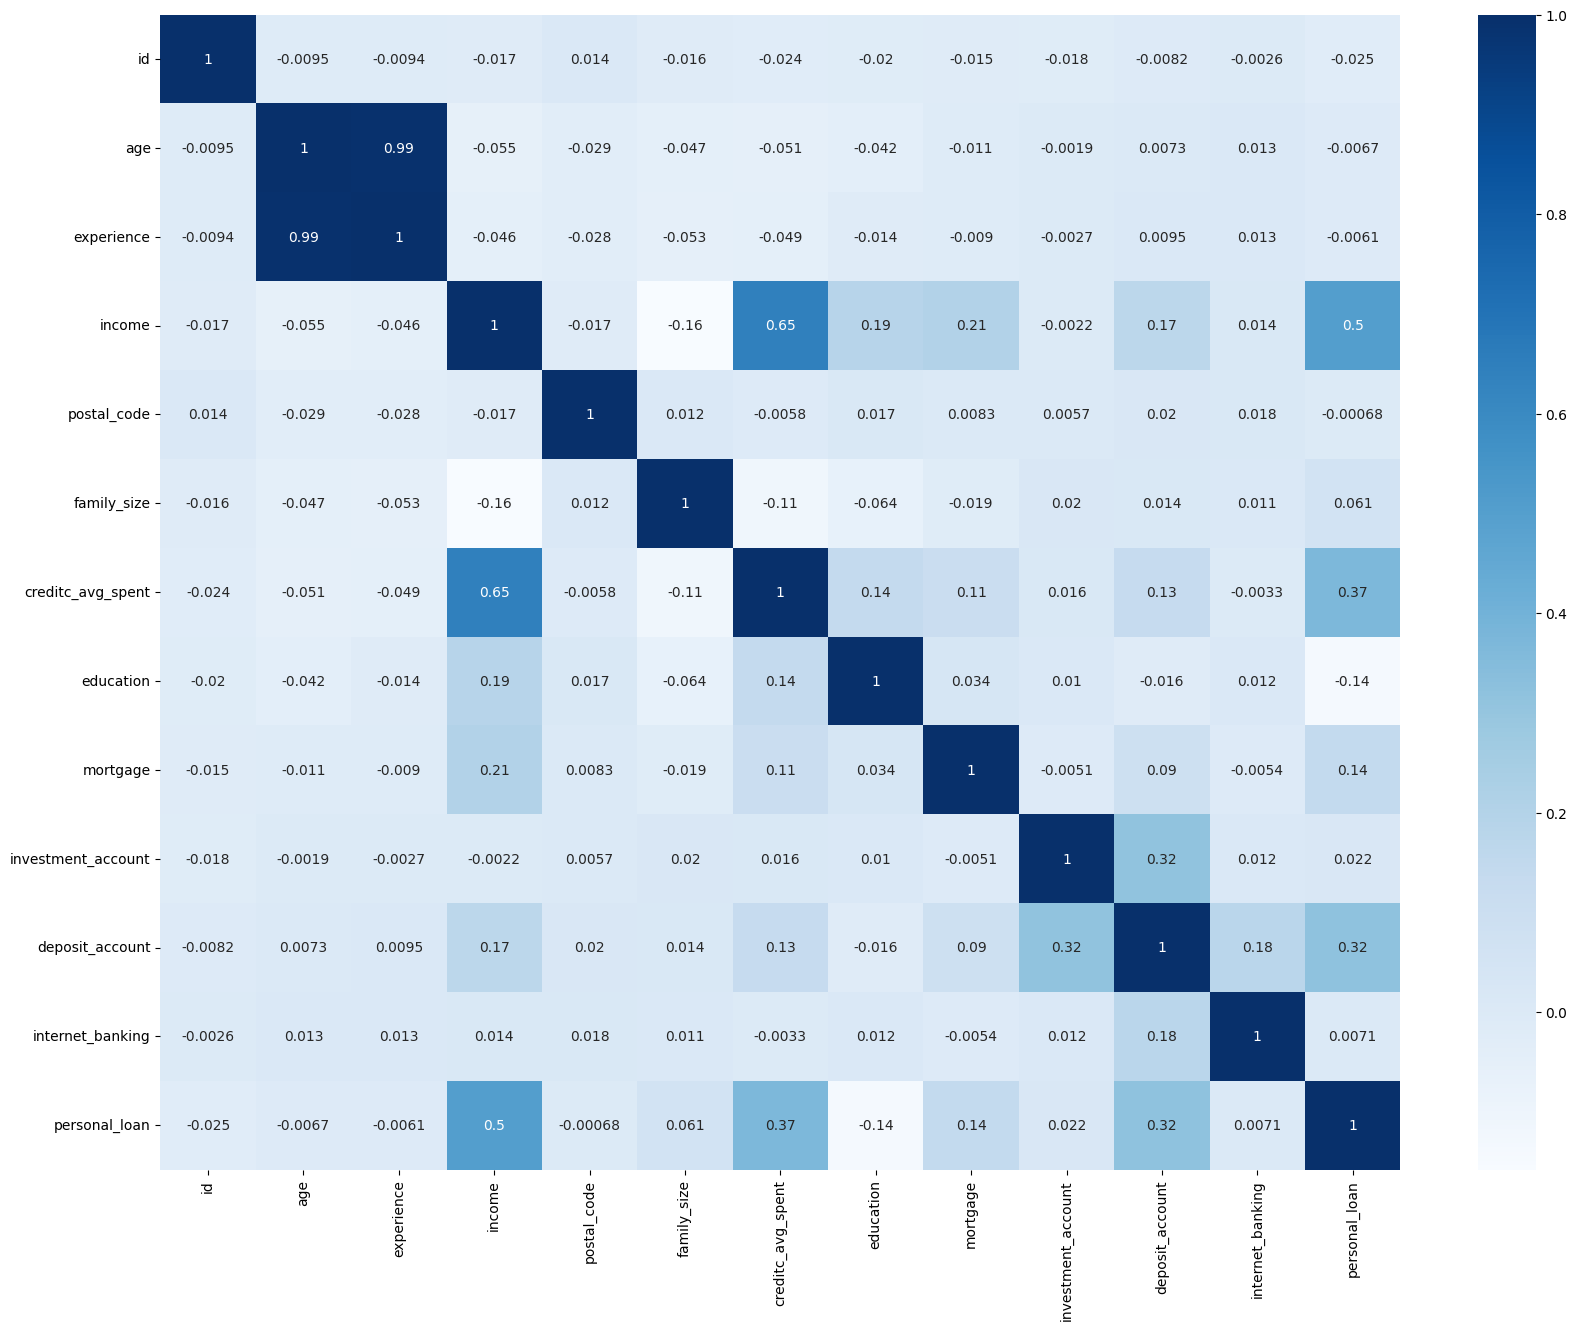

In [84]:
corr = feat_df.corr()
sns.heatmap(corr, cmap='Blues', annot=True)
plt.gcf().set_size_inches(20, 15)
plt.show()


## Age, experience, internet_banking and postal_code have little to no impact on the decision for personal_loan, so we ll drop them

In [85]:
cols_to_encode = ['education', 'investment_account']
cols_to_scale = ['income', 'family_size','creditc_avg_spent', 'mortgage']

In [86]:
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                           ('ordinal', OrdinalEncoder())])
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='mean', missing_values=np.nan)),
                           ('scalar', StandardScaler())])

In [87]:
preprocess = ColumnTransformer(
transformers=[
    ('num', num_transformer, cols_to_scale),
    ('cat', cat_transformer, cols_to_encode)
])

In [125]:
y = df['personal_loan']
X = df.drop(columns=['personal_loan', 'postal_code'])

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [127]:
knn_model = Pipeline(steps=[('preprocess', preprocess),
                          ('model', KNeighborsClassifier())])
knn_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['income', 'family_size',
                                                   'creditc_avg_spent',
                                                   'mortgage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['education',
                                                   'investment_account'])])),
                ('model', KNeighborsClassifier())])

In [128]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
rf_model = Pipeline(steps=[('preprocess', preprocess),
                          ('model', RandomForestClassifier(class_weight='balanced'))])
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['income', 'family_size',
                                                   'creditc_avg_spent',
                                                   'mortgage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['education',
                                                   'investment_account'])])),
                ('model', RandomForestClassifier(class_weight='balanced'))])

In [64]:
def model_performance(model, X, y, X_test, y_test):
    print(f'Model Score is {model.score(X_test, y_test)}')
    print("============================================\n============================================")
    scores_cv = cross_val_score(rf_model, X, y, cv=10, scoring='roc_auc')
    print(f'Model Scores with CV based on ROC AUC Scoring is {scores_cv}')
    print("============================================\n============================================")
    
    y_pred = model.predict(X_test)

    print('The classification report is:')
    print(classification_report(y_test, y_pred))
    # Load the predicted probabilities and true labels
    print("============================================\n============================================")


    # Compute the ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred)

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curve')
    plt.legend(loc='lower right')
    plt.show()

Model Score is 0.9718592964824121
Model Scores with CV based on ROC AUC Scoring is [0.99618056 0.99815603 0.99575445 0.99703044 0.99897921 0.99529046
 0.99895601 0.99946641 0.98812175 0.99807442]
The classification report is:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       899
         1.0       0.97      0.73      0.83        96

    accuracy                           0.97       995
   macro avg       0.97      0.86      0.91       995
weighted avg       0.97      0.97      0.97       995



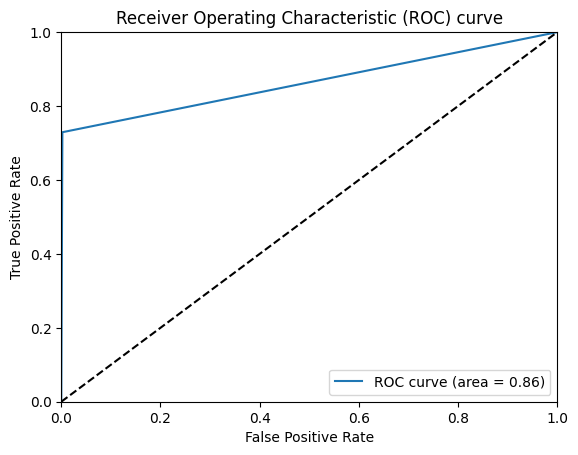

In [65]:
model_performance(knn_model, X, y, X_test, y_test)

Model Score is 0.9879396984924623
Model Scores with CV based on ROC AUC Scoring is [0.98608796 0.99810875 0.99491927 0.99761043 0.99897921 0.99605605
 0.99895601 0.99946641 0.99742483 0.99814402]
The classification report is:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       899
         1.0       0.97      0.91      0.94        96

    accuracy                           0.99       995
   macro avg       0.98      0.95      0.96       995
weighted avg       0.99      0.99      0.99       995



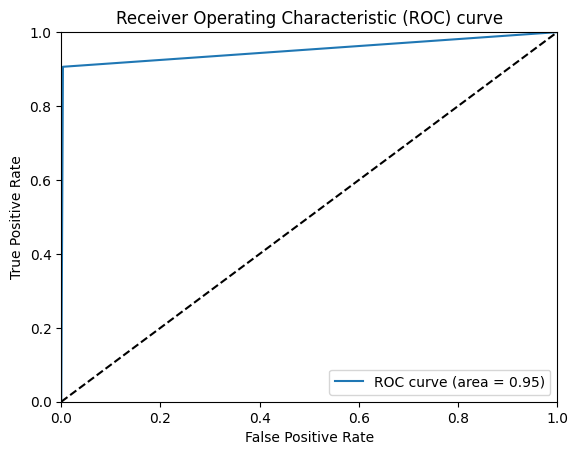

In [67]:
model_performance(rf_model, X, y, X_test, y_test)

In [145]:
joblib.dump(rf_model,'../model/pipeline_model.pkl')

['../model/pipeline_model.pkl']


### Lets try the SMOTE and check the performance 

In [132]:
# Preprocess the categorical columns using ordinal encoding
encoder = OrdinalEncoder()
 
X_train_encoded = X_train[['education', 'investment_account','income', 'family_size','creditc_avg_spent', 'mortgage']]
X_test_encoded = X_test[['education', 'investment_account','income', 'family_size','creditc_avg_spent', 'mortgage']]
y_train_encoded = y_train.copy()
y_test_encoded = y_test.copy()
le = LabelEncoder()
scalar = StandardScaler()

X_train_encoded[cols_to_encode] = encoder.fit_transform(X_train[cols_to_encode])
X_train_encoded[cols_to_scale] = scalar.fit_transform(X_train[cols_to_scale])

X_test_encoded[cols_to_encode] = encoder.transform(X_test[cols_to_encode])
X_test_encoded[cols_to_scale] = scalar.transform(X_test[cols_to_scale])

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Apply SMOTE resampling to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train_encoded)


/var/folders/kp/fq5v4zt954n8wtmwm0n_n0j80000gn/T/ipykernel_84686/2520287923.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_encoded[cols_to_encode] = encoder.fit_transform(X_train[cols_to_encode])
/var/folders/kp/fq5v4zt954n8wtmwm0n_n0j80000gn/T/ipykernel_84686/2520287923.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_encoded[cols_to_scale] = scalar.fit_transform(X_train[cols_to_scale])
/var/folders/kp/fq5v4zt954n8wtmwm0n_n0j80000gn/T/ipykernel_84686/2520287923.py:14: SettingWithC

In [131]:
unique_values, counts = np.unique(y_train_resampled, return_counts=True)
print(unique_values)
print(counts)

[0 1]
[3593 3593]


In [134]:
rf =  RandomForestClassifier()

In [136]:
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

In [138]:
y_pred = rf.predict(X_test_encoded)

In [143]:
report = classification_report(y_test_encoded, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       899
           1       0.96      0.93      0.94        96

    accuracy                           0.99       995
   macro avg       0.97      0.96      0.97       995
weighted avg       0.99      0.99      0.99       995



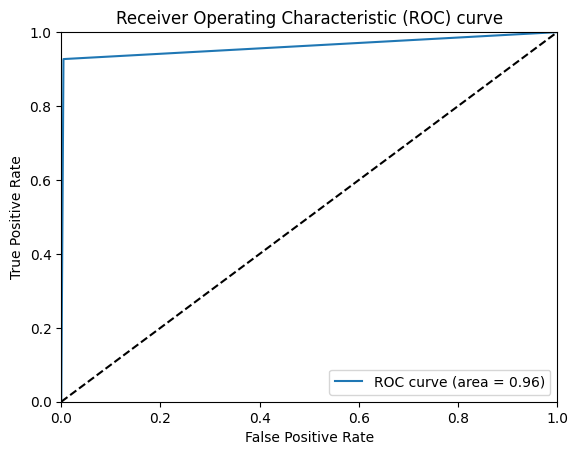

In [144]:
    # Compute the ROC AUC score
    roc_auc = roc_auc_score(y_test_encoded, y_pred)

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curve')
    plt.legend(loc='lower right')
    plt.show()

In [152]:
joblib.dump(encoder,'../model/endoder.pkl')
joblib.dump(scalar,'../model/scalar.pkl')
joblib.dump(rf,'../model/rf_model.pkl')

['../model/rf_model.pkl']